# Libraries

In [3]:
#Library definition 
import pandas as pnd
from matplotlib import pyplot as matplt
import numpy as npy
from datetime import datetime
import warnings 
import statsmodels.api as stModel
import calendar
import scipy.stats as stats
import numpy as numpy
warnings.simplefilter('ignore')
%matplotlib inline

# Functions Definitions

In [4]:
def plot_specs(title,xlab,ylab):
    #plotting the time series
    matplt.figure(figsize=(12,5))
    matplt.title(title)
    matplt.ylabel(ylab)
    matplt.xlabel(xlab)
    matplt.grid(True)
    
def pers_benchmark(ddf,var,metrictype):
    MAE=[]
    MAPE=[]
    for iter in range(1,97):
        dataframe= pnd.concat([ddf[var], ddf[var].shift(iter)], axis=1)
        dataframe.columns=['t','t'+str(iter)]
        dataframe=dataframe.dropna()
        
        dataframe['Abs_Error']=numpy.abs(dataframe['t']-dataframe['t'+str(iter)])
        MAE.append(numpy.mean(dataframe['Abs_Error']))
        
        dataframe['Abs_perc_Error']=numpy.abs((dataframe['t']-dataframe['t'+str(iter)])/dataframe['t']*100)
        MAPE.append(numpy.mean(dataframe['Abs_perc_Error']))
    if metrictype=='MAE':
        return MAE
    elif metrictype=='MAPE':
        return MAPE

# Question 1

In [6]:
Grid_df=pnd.read_csv('../Dataset/EirGridSystemDemand2014.csv',parse_dates=[['Date', 'Time']])
Grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date_Time  35040 non-null  datetime64[ns]
 1   Demand     35035 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.6 KB


In [7]:
#Filling the null values that are available in the data set by interpolation
Grid_df['Demand']=Grid_df['Demand'].interpolate(method='linear')
Grid_df.isnull().sum()


Date_Time    0
Demand       0
dtype: int64

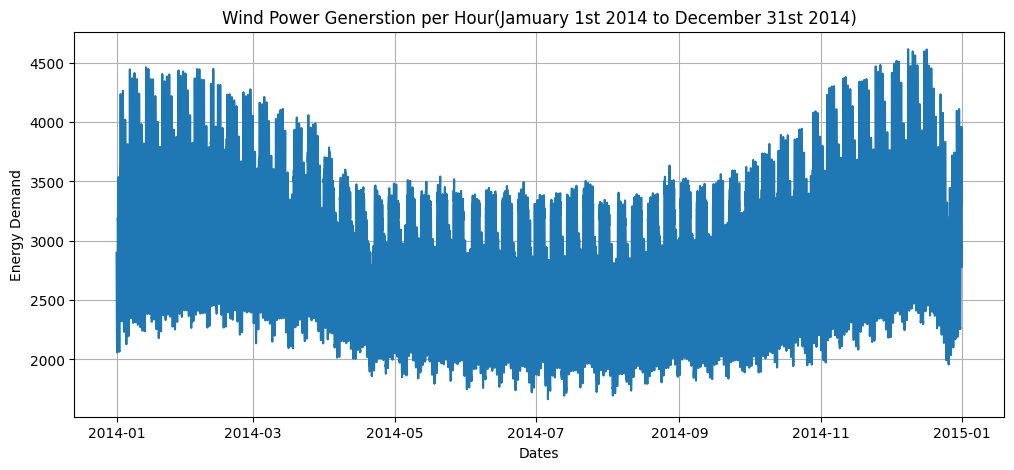

In [9]:
new_Grid_df=Grid_df.set_index('Date_Time')
nnew_Grid_df=Grid_df.set_index('Date_Time')
new_Grid_df
plot_specs('Wind Power Generstion per Hour(Jamuary 1st 2014 to December 31st 2014)','Dates','Energy Demand')

matplt.plot(new_Grid_df.index,new_Grid_df['Demand'])
matplt.show()

# Question 2

<BarContainer object of 961 artists>

<Figure size 1200x400 with 0 Axes>

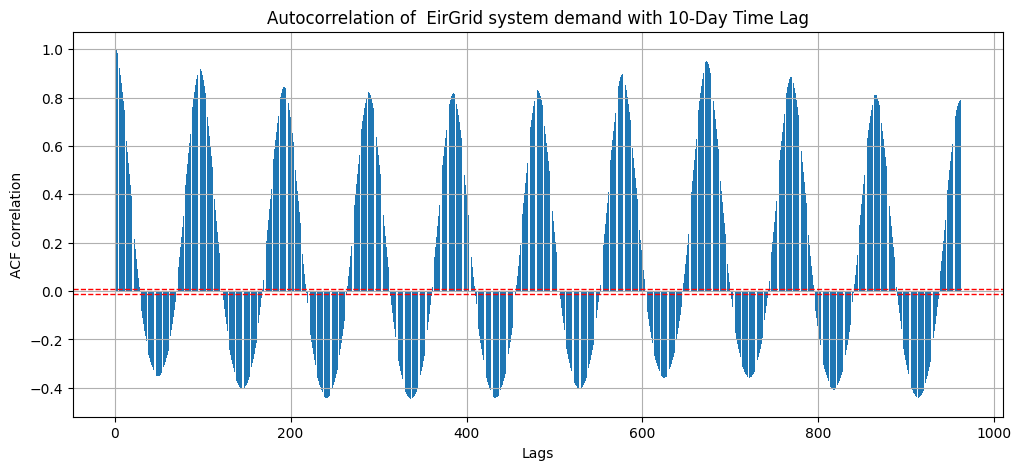

In [10]:

#plotting the time series
matplt.figure(figsize=(12,4))

#calculating the autocorrelation coefficient over 10days
CorrCoeff= stModel.tsa.acf(Grid_df['Demand'], nlags =960)

# calculating the corresponding significance level value on the ACF 
ps_ive_signfcnce=1.96/numpy.sqrt(len(Grid_df['Demand']))
ng_ive_signfcnce=-1.96/numpy.sqrt(len(Grid_df['Demand']))


plot_specs('Autocorrelation of  EirGrid system demand with 10-Day Time Lag','Lags','ACF correlation')
matplt.axhline(y=ps_ive_signfcnce,color='red',linestyle='--',linewidth=1)
matplt.axhline(y=ng_ive_signfcnce,color='red',linestyle='--',linewidth=1)
matplt.bar(range(1,962),CorrCoeff)
# CorrCoeff

# Question 3

In [11]:
new_Grid_df["day_of_year"] = new_Grid_df.index.dayofyear

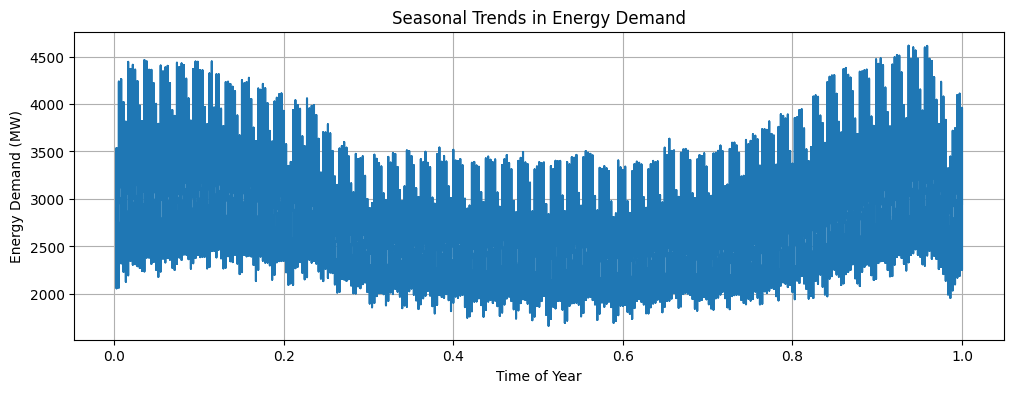

In [13]:
new_Grid_df['time_of_year']=new_Grid_df.index.dayofyear/365

#plotting the time series
matplt.figure(figsize=(12,4))
matplt.title("Seasonal Trends in Energy Demand")
matplt.ylabel("Energy Demand (MW)")
matplt.xlabel('Time of Year')
matplt.grid(True)
matplt.plot(new_Grid_df["time_of_year"],new_Grid_df['Demand'])

# Question 4

In [14]:
#12 Month grouping
monthly_df=new_Grid_df.groupby(new_Grid_df.index.month).mean()

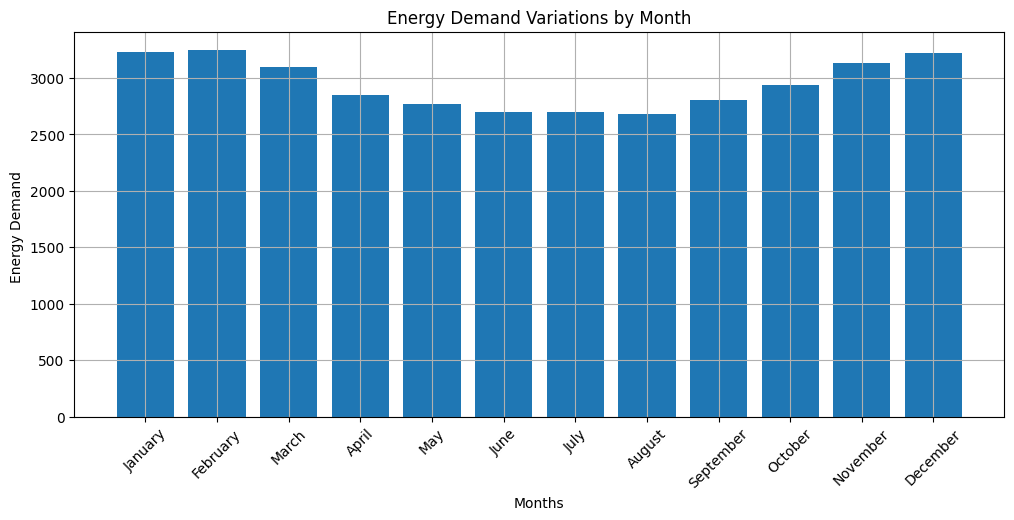

In [16]:
monthname=[]
for i in range(1,13):
    monthname.append(calendar.month_name[i])
monthname
plot_specs('Energy Demand Variations by Month','Months','Energy Demand ')
matplt.bar(monthly_df.index,monthly_df['Demand'])
matplt.xticks(range(1,13),monthname,rotation=45)
matplt.show()

# Question 5

<BarContainer object of 24 artists>

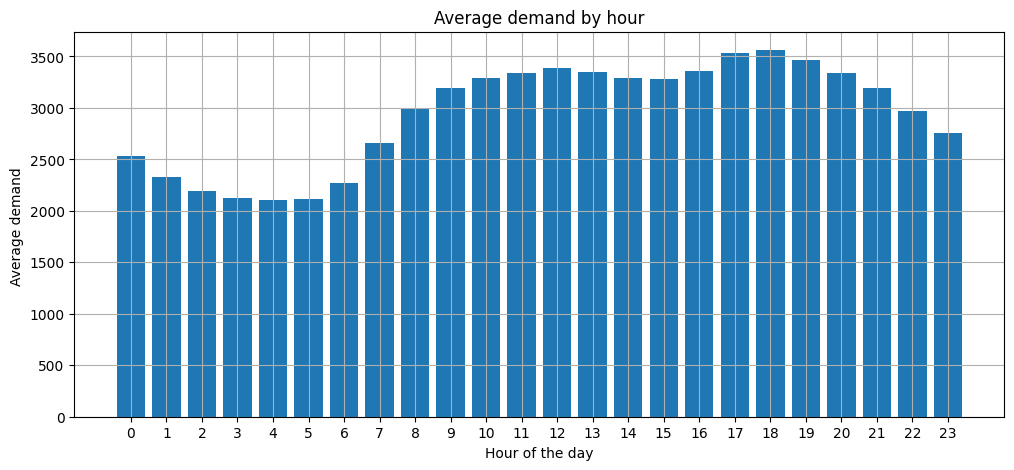

In [18]:
# 12 Month grouping
hourly_demand = new_Grid_df.groupby(new_Grid_df.index.hour)['Demand'].mean()
#hourly_demand


plot_specs('Average demand by hour','Hour of the day','Average demand ')
matplt.xticks(range(0,24),range(0,24))
matplt.bar(range(0,24),hourly_demand)

# Question 6

In [20]:
#Grouping time series in week days
hourly_demand = new_Grid_df.groupby(new_Grid_df.index.weekday)['Demand'].mean()

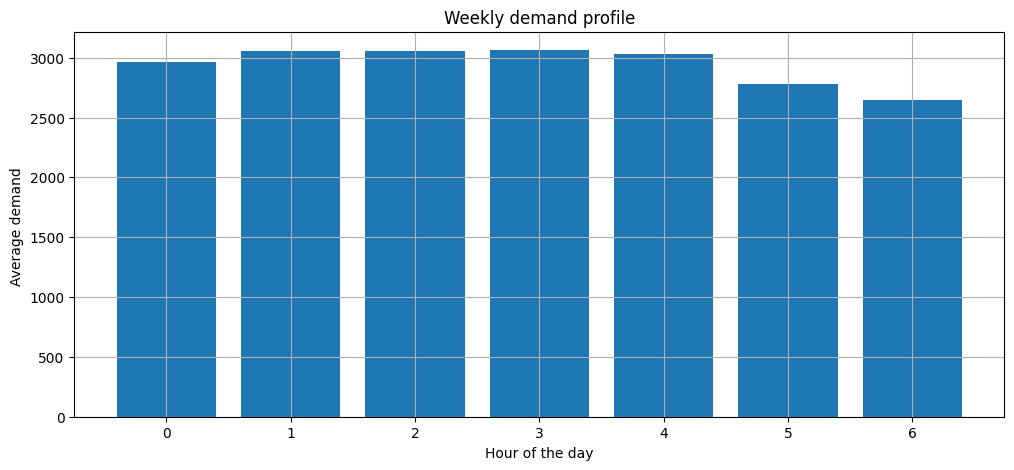

In [21]:
hourly_demand
#plotting the weekly demand Profile
plot_specs('Weekly demand profile','Hour of the day','Average demand ')
matplt.bar(range(0,7),hourly_demand)
matplt.show()

# Question 7

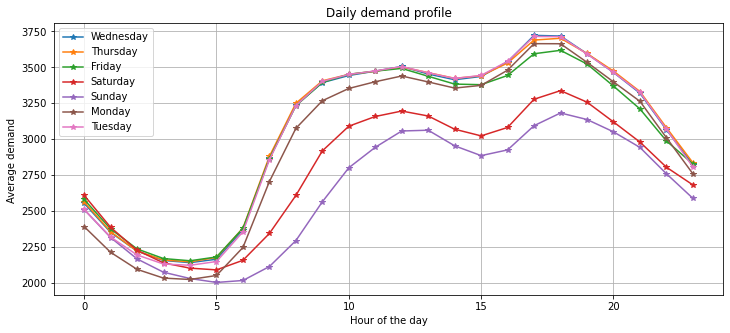

In [228]:
# creating an empty dictionary 
dailyDmd = dict()

# unique days 
Record_days=nnew_Grid_df.index.day_name().unique()

#
for day in Record_days:
    wed=nnew_Grid_df[nnew_Grid_df.index.day_name()==day]
    wed_ho=wed['Demand'].groupby([wed.index.hour]).mean()
    dailyDmd[day]=wed_ho
# pnd.DataFrame(dailyDmd)
plot_specs('Daily demand profile','Hour of the day','Average demand ')
for day in Record_days:
    matplt.plot(range(0,24),dailyDmd[day],marker='*',label=day)
    matplt.legend()

In [22]:
wed=nnew_Grid_df[nnew_Grid_df.index.day_name()=='Monday']
wed_ho=wed['Demand'].groupby([wed.index.hour]).mean()
# wed_ho

# Question 8

In [23]:
#Resampling the data on daily frequency
DaillyGrouping=nnew_Grid_df.resample('d').mean()
DaillyGrouping=DaillyGrouping.reset_index()

#Separating the weekend demands and the other days of the week 
DaillyGrouping['WeekDay']=DaillyGrouping['Date_Time'].apply(lambda x: x.dayofweek)

#Monday to friday
Monday_friday=DaillyGrouping[DaillyGrouping['WeekDay'].isin([0,1,2,3,4])]['Demand']

#Saturday to sunday
saturday_sunday = DaillyGrouping[DaillyGrouping['WeekDay'].isin([5, 6])]['Demand']

saturday_sunday
#Perfoming 2 sample T-Test using Scipy 
results= stats.ttest_ind(a=saturday_sunday, b=Monday_friday, equal_var=True)
print(results[0]," ",results[1])

if(results[1]< 0.05):
    print("The null hypothesis (average demand in weekends== average demand in other days)is rejected")

-11.434779040900064   4.5479789337995976e-26
The null hypothesis (average demand in weekends== average demand in other days)is rejected


# Question 9

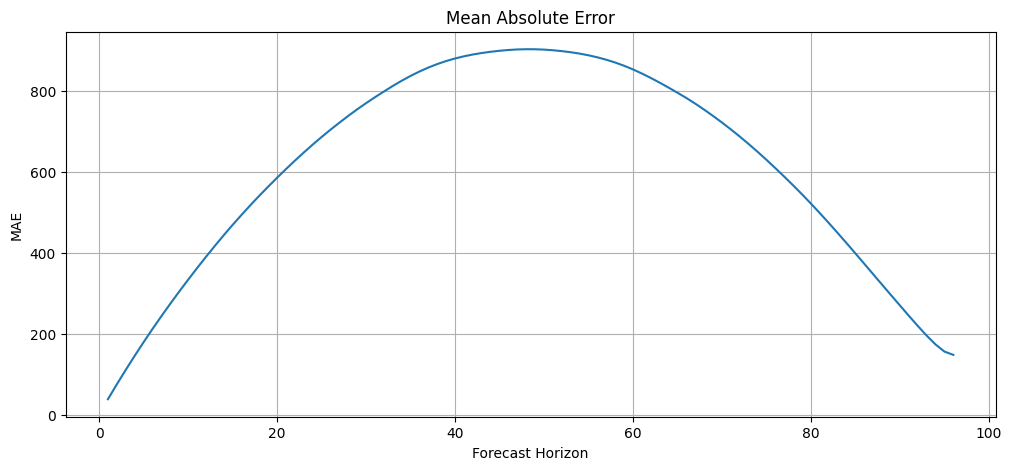

In [24]:
resetted=nnew_Grid_df.reset_index()

#Calculating the Mid index of the data frame
mid=len(resetted)/2

#first half Data frame 
f_half=resetted['Demand'].iloc[:int(mid)]

#Second half data frame
s_half=pnd.DataFrame(resetted['Demand'].iloc[int(mid):])
s_half

MAE=[]
perc=[]

#calling the function that does the persistence fore casting and calculate the MAE
pers_benchmark(s_half,'Demand','MAE')

plot_specs('Mean Absolute Error','Forecast Horizon','MAE')
matplt.plot(range(1,97),pers_benchmark(s_half,'Demand','MAE'))
matplt.show()

In [234]:
# pers_benchmark(s_half,'Demand','MAE')

# Question 10

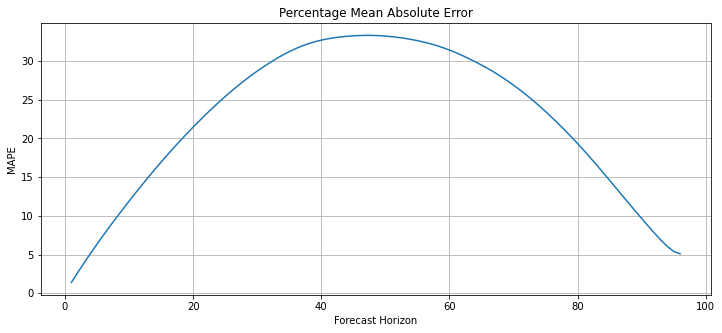

In [235]:
plot_specs('Percentage Mean Absolute Error','Forecast Horizon','MAPE')
matplt.plot(range(1,97),pers_benchmark(s_half,'Demand','MAPE'))
matplt.show()
